# Model Building

### Settings/Functions
Read in settings and functions.

In [673]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from patsy import dmatrices
import sys
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.api import abline_plot
from sklearn.preprocessing import MinMaxScaler
from statsmodels.compat import lzip
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Data

In [674]:
# Import prepped dataset
data_loc = 'C://Users/User/Documents/GitHub/Python/Ohio Reading/data/'
data = pd.read_csv(data_loc+'reading_clean.csv')
data.head()

,tot_pop_log,median_inc_log,year,after,ohio,school_district,number_tested,pct_prof_or_above,tot_pop,perc_male,perc_female,perc_under5,perc_5to19,perc_20plus,perc_caucasian,perc_otherethnicity,perc_nobach,perc_bachplus,median_inc,interaction
0,10.080922,10.476781,2008,0,1,Adams County/Ohio Valley Local School District...,315,67.6,23882,0.50,0.50,0.07,0.18,0.75,0.97,0.03,0.90,0.10,35481,0
1,10.023357,10.396414,2013,1,1,Adams County/Ohio Valley Local School District...,283,78.5,22546,0.50,0.50,0.07,0.19,0.74,0.97,0.03,0.90,0.10,32741,1
2,12.159542,10.436261,2008,0,1,"Akron City School District, Ohio",1801,60.2,190906,0.48,0.52,0.07,0.17,0.76,0.63,0.37,0.82,0.18,34072,0
3,12.157932,10.323480,2013,1,1,"Akron City School District, Ohio",1700,68.8,190599,0.48,0.52,0.07,0.16,0.77,0.61,0.39,0.81,0.19,30438,1
4,10.029018,10.421358,2008,0,1,"Alliance City School District, Ohio",199,61.3,22674,0.48,0.52,0.06,0.17,0.77,0.87,0.13,0.88,0.12,33568,0


### Simple Plots

 * A simple way to gauge the effect of the reading program was to fit a simple regression model. It is easy to see that score increases a few points on average after the program was enacted. The question stills remains whether or not there were other factors that caused this increase.

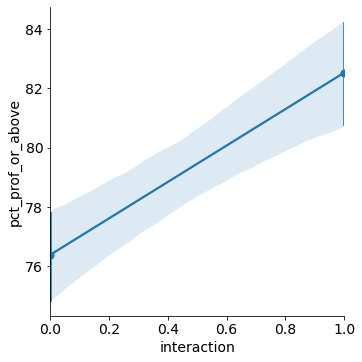

In [675]:
sb.lmplot(x="interaction", y="pct_prof_or_above", data=data, x_estimator=np.mean);

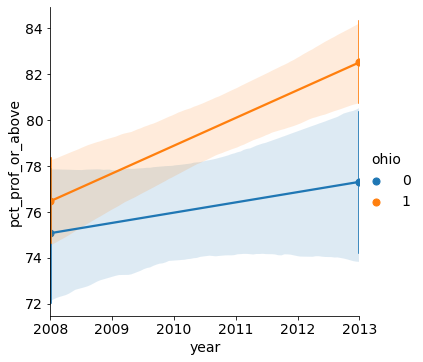

In [676]:
# Viewing the fit of the regression when breaking the state's into groups
# The orange line (which represents Ohio shows that there was a steeper improvement in testing than in Iowa)
sb.lmplot(x="year", y="pct_prof_or_above", hue="ohio", data=data, x_estimator=np.mean);

### Hypotheses
* **Null Hypothesis:** The null hypothesis is that the Ohio Third Grade Reading Guarantee had no impact on students as measured by the Ohio Achievement Assessment (OAA) and its Iowa equivalent.
* **Alternative Hypothesis:** The alternative hypothesis is that the Ohio Third Grade Reading Guarantee did have an impact on students as measured by the OAA and its Iowa equivalent.

### Difference-in-Difference Model

The model used for this analysis is a difference-in-difference model.

**Pct_Proficient_or_Abovei = β0 + β1Ohioi + β2Afteri + β3Ohio*After_Implementationi + β4-nControlsi + εi**

### Variable Selection
For the difference-in-difference model, there is no need to use advanced variable selection techniques, such as step-wise selection. The variables chosen to be in the dataset were selected due to their relevance in previous studies that looked at school testing performance and related socioeconomic variables. 

In [729]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tot_pop_log          348 non-null    float64
 1   median_inc_log       348 non-null    float64
 2   year                 348 non-null    int64  
 3   after                348 non-null    int64  
 4   ohio                 348 non-null    int64  
 5   school_district      348 non-null    object 
 6   number_tested        348 non-null    int64  
 7   pct_prof_or_above    348 non-null    float64
 8   tot_pop              348 non-null    int64  
 9   perc_male            348 non-null    float64
 10  perc_female          348 non-null    float64
 11  perc_under5          348 non-null    float64
 12  perc_5to19           348 non-null    float64
 13  perc_20plus          348 non-null    float64
 14  perc_caucasian       348 non-null    float64
 15  perc_otherethnicity  348 non-null    flo

In [678]:
# Downselect only include variables of interest for the model
df = data[['pct_prof_or_above','after','ohio','interaction','tot_pop_log', 'perc_caucasian'
           ,'perc_male','perc_5to19','perc_bachplus','median_inc_log']]

In [679]:
# Creating a list of independent variables to use for modeling
featureList = df.drop(['pct_prof_or_above'], axis=1)
features = "+".join(featureList)
print(features)

after+ohio+interaction+tot_pop_log+perc_caucasian+perc_male+perc_5to19+perc_bachplus+median_inc_log


### Linear Regression

In [680]:
lm = ols('pct_prof_or_above ~' + features, df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      pct_prof_or_above   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     142.3
Date:                Mon, 15 Mar 2021   Prob (F-statistic):          2.80e-109
Time:                        19:46:59   Log-Likelihood:                -1062.2
No. Observations:                 348   AIC:                             2144.
Df Residuals:                     338   BIC:                             2183.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -97.7504     18.389     -5.

In [681]:
# Checking VIF
y, X = dmatrices('pct_prof_or_above ~' + features, df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor        features
0  4357.310724       Intercept
1     6.030771           after
2     2.127107            ohio
3     7.032960     interaction
4     1.111831     tot_pop_log
5     1.504633  perc_caucasian
6     1.205063       perc_male
7     1.883824      perc_5to19
8     2.993700   perc_bachplus
9     5.089323  median_inc_log


* The only control variable that has a high VIF at the moment is 'median_inc_log' but since it is just slightly over the limit of 5 I have decided to keep it in for the time being.
* The intercept clearly has high VIF and will need to be corrected.
* The variable 'perc_male' was highly insignificant and will be removed from the model going forward.

In [682]:
# Removing the varibale 'perc_male' from the dataset
del featureList['perc_male']

In [683]:
# Updating the features list
features = "+".join(featureList)
print(features)

after+ohio+interaction+tot_pop_log+perc_caucasian+perc_5to19+perc_bachplus+median_inc_log


In [684]:
# Re-running the regression with updated features list
lm = ols('pct_prof_or_above ~' + features, df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      pct_prof_or_above   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     160.5
Date:                Mon, 15 Mar 2021   Prob (F-statistic):          2.21e-110
Time:                        19:47:11   Log-Likelihood:                -1062.3
No. Observations:                 348   AIC:                             2143.
Df Residuals:                     339   BIC:                             2177.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -97.3493     18.292     -5.

In [685]:
# Checking VIF on the updated model
# The intercept's constant is unusally high
y, X = dmatrices('pct_prof_or_above ~' + features, df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor        features
0  4323.253007       Intercept
1     6.023604           after
2     2.091020            ohio
3     7.030578     interaction
4     1.103862     tot_pop_log
5     1.494681  perc_caucasian
6     1.809927      perc_5to19
7     2.825044   perc_bachplus
8     4.640681  median_inc_log


In [686]:
lm_pred = pd.DataFrame(lm.fittedvalues)
lm_resids = pd.DataFrame(lm.resid)
resids = pd.concat([lm_pred,lm_resids],axis=1)
resids.columns=['pred','resids']
resids

,pred,resids
0,71.823177,-4.223177
1,77.656797,0.843203
2,56.912157,3.287843
3,62.819424,5.980576
4,69.567926,-8.267926
...,...,...
343,80.623930,-5.123930
344,51.574306,6.825694
345,58.650304,-2.750304
346,68.288160,-8.988160


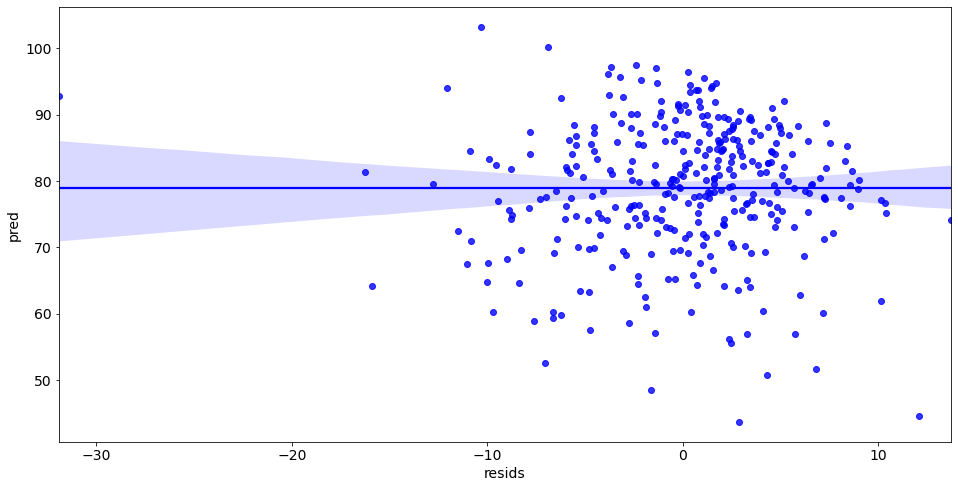

In [687]:
# Plotting the residuals
sb.regplot(x='resids',y='pred', data= resids, scatter = True, color = 'blue');

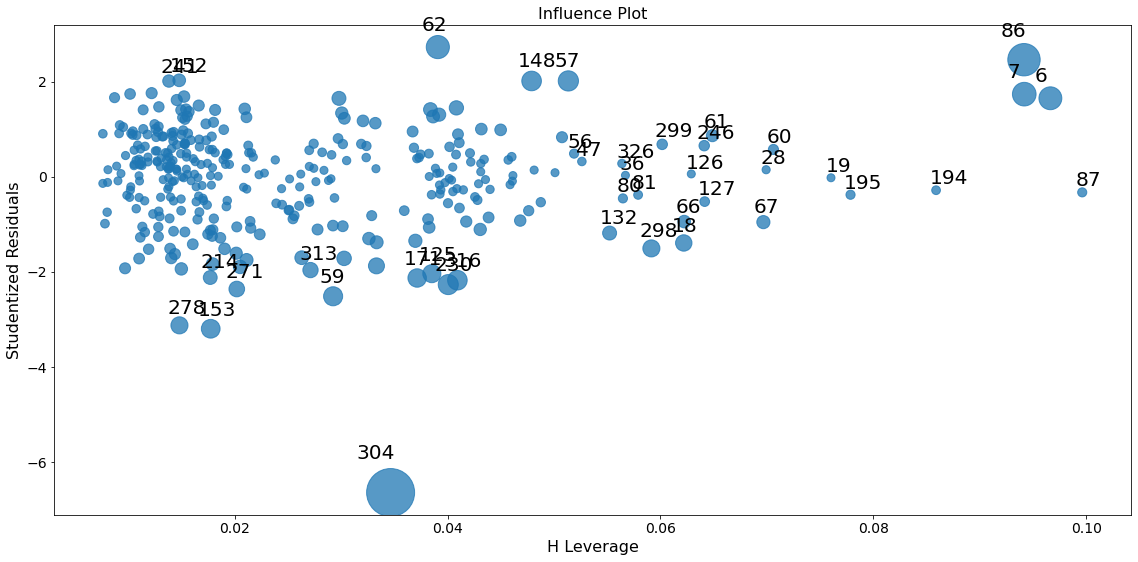

In [688]:
# Checking the influence of observations
fig = sm.graphics.influence_plot(lm, criterion="cooks")
fig.tight_layout(pad=1.0)

In [689]:
# Performing Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(lm.resid, lm.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 12.439366360683742),
 ('p-value', 0.1326505941064917),
 ('f-value', 1.5708581302196367),
 ('f p-value', 0.13230098589687495)]

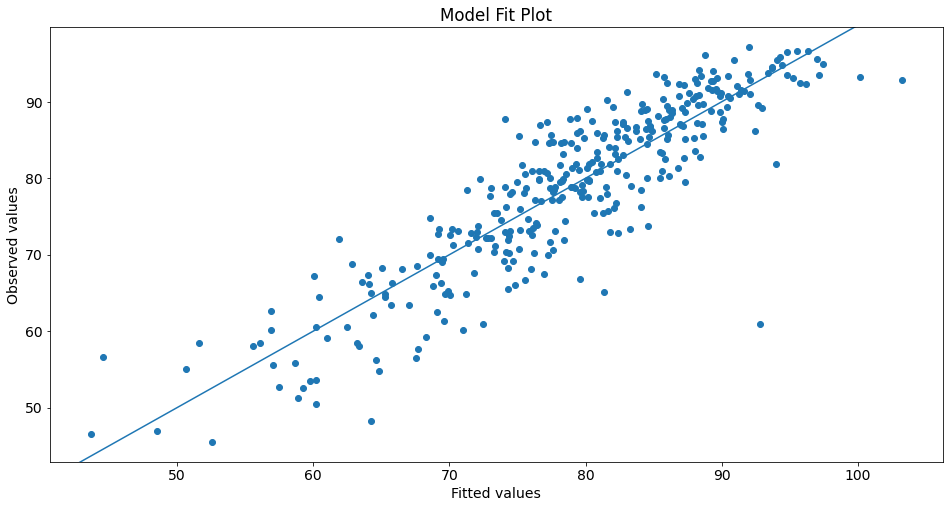

In [690]:
y = df.pct_prof_or_above
yhat = lm.fittedvalues

fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)

ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

### Scaling

* In the simple regression performed above, the intercept still has an extraordinarily high VIF. There are also a number of variables that are heavily influencing the model. To try to correct these issues, I am going to scale that independent variables and re-run the model.

In [691]:
# Applying a scaler to the independent variables
scaler = MinMaxScaler()
scaled_df = featureList.copy()
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
scaled_df.head()

,after,ohio,interaction,tot_pop_log,perc_caucasian,perc_5to19,perc_bachplus,median_inc_log
0,0.0,1.0,0.0,0.060247,0.989130,0.578947,0.044776,0.356008
1,1.0,1.0,1.0,0.042502,0.989130,0.631579,0.044776,0.310107
2,0.0,1.0,0.0,0.700991,0.619565,0.526316,0.164179,0.332865
3,1.0,1.0,1.0,0.700495,0.597826,0.473684,0.179104,0.268451
4,0.0,1.0,0.0,0.044247,0.880435,0.526316,0.074627,0.324354


In [692]:
# Adding the dependent variable back onto the scaled dataset
scaled_df = pd.concat([df.pct_prof_or_above, scaled_df], axis=1)
scaled_df.head()

,pct_prof_or_above,after,ohio,interaction,tot_pop_log,perc_caucasian,perc_5to19,perc_bachplus,median_inc_log
0,67.6,0.0,1.0,0.0,0.060247,0.989130,0.578947,0.044776,0.356008
1,78.5,1.0,1.0,1.0,0.042502,0.989130,0.631579,0.044776,0.310107
2,60.2,0.0,1.0,0.0,0.700991,0.619565,0.526316,0.164179,0.332865
3,68.8,1.0,1.0,1.0,0.700495,0.597826,0.473684,0.179104,0.268451
4,61.3,0.0,1.0,0.0,0.044247,0.880435,0.526316,0.074627,0.324354


In [693]:
scaled = ols('pct_prof_or_above ~' + features, scaled_df).fit()
print(scaled.summary())

                            OLS Regression Results                            
Dep. Variable:      pct_prof_or_above   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     160.5
Date:                Mon, 15 Mar 2021   Prob (F-statistic):          2.21e-110
Time:                        19:51:21   Log-Likelihood:                -1062.3
No. Observations:                 348   AIC:                             2143.
Df Residuals:                     339   BIC:                             2177.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         43.1424      2.316     18.

In [694]:
# Checking VIF
y, X = dmatrices('pct_prof_or_above ~' + features, scaled_df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

   VIF Factor        features
0   69.282570       Intercept
1    6.023604           after
2    2.091020            ohio
3    7.030578     interaction
4    1.103862     tot_pop_log
5    1.494681  perc_caucasian
6    1.809927      perc_5to19
7    2.825044   perc_bachplus
8    4.640681  median_inc_log


In [695]:
scaled_pred = pd.DataFrame(scaled.fittedvalues)
scaled_resids = pd.DataFrame(scaled.resid)
scaled.resids = pd.concat([scaled_pred,scaled_resids],axis=1)
scaled.resids.columns=['pred','resids']
scaled.resids

,pred,resids
0,71.823177,-4.223177
1,77.656797,0.843203
2,56.912157,3.287843
3,62.819424,5.980576
4,69.567926,-8.267926
...,...,...
343,80.623930,-5.123930
344,51.574306,6.825694
345,58.650304,-2.750304
346,68.288160,-8.988160


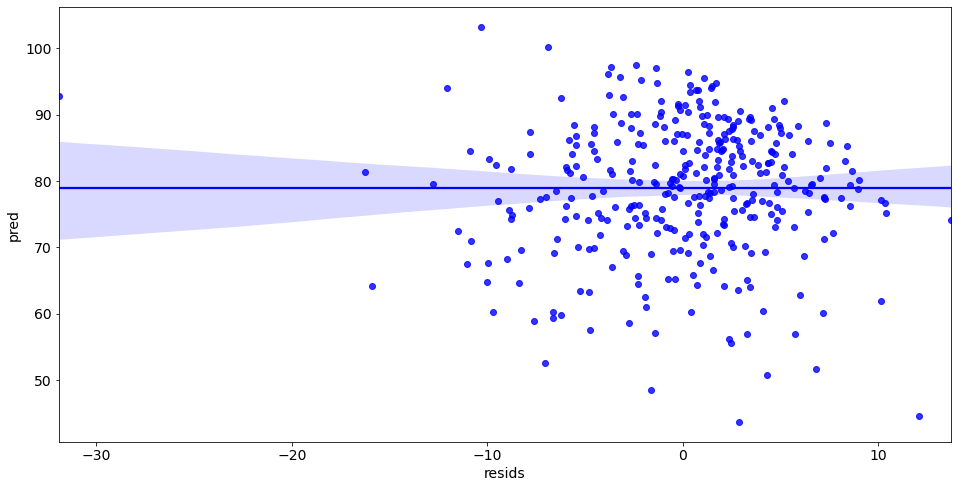

In [696]:
# Plotting the residuals
sb.regplot(x='resids',y='pred', data=scaled.resids, scatter = True, color = 'blue');

In [697]:
# Performing Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(scaled.resid, scaled.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 12.439366360683433),
 ('p-value', 0.13265059410650398),
 ('f-value', 1.5708581302195983),
 ('f p-value', 0.13230098589688705)]

### Box-Cox Transformation

* Even with the standarization of the independent variables, the VIF for the intercept is still high. To check if this could be corrected some more, I decided to use Box-Cox transformation on the dependent variable and re-run the regression.

In [700]:
# Transforming the dependent variable 
fitted_data, fitted_lamba = stats.boxcox(df.pct_prof_or_above) 

Lambda value used for Transformation: 2.889601162699145


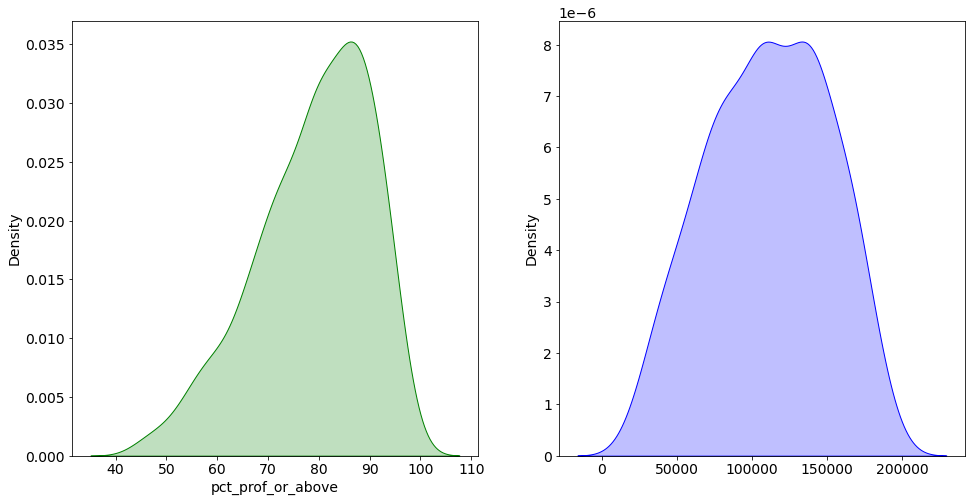

In [719]:
fig, ax = plt.subplots(1, 2) 
# Plotting the original vs transformed data
sb.kdeplot(data=df, x='pct_prof_or_above', ax=ax[0]
          ,color='green', fill=True) 
  
sb.kdeplot(fitted_data, ax = ax[1]
          ,color='blue', fill=True) 
 
print(f"Lambda value used for Transformation: {fitted_lambda}") 

# The transformed dependent variable results in a normal distribution.

In [720]:
# Added the tranformed variable onto the dataset
boxcox = pd.DataFrame(fitted_data, columns = ['pct_prof_boxcox'])
scaled_df = pd.concat([scaled_df,boxcox ], axis=1)
scaled_df

,pct_prof_boxcox
0,67139.168500
1,103413.730886
2,48026.734389
3,70641.133085
4,50606.580417
...,...
343,92401.317787
344,43993.376671
345,38768.715470
346,45981.139686


In [723]:
# Changing the data type of the transformed variable to numeric
pd.to_numeric(scaled_df.pct_prof_boxcox)

,pct_prof_or_above,after,ohio,interaction,tot_pop_log,perc_caucasian,perc_5to19,perc_bachplus,median_inc_log,pct_prof_boxcox
0,67.6,0.0,1.0,0.0,0.060247,0.989130,0.578947,0.044776,0.356008,67139.168500
1,78.5,1.0,1.0,1.0,0.042502,0.989130,0.631579,0.044776,0.310107,103413.730886
2,60.2,0.0,1.0,0.0,0.700991,0.619565,0.526316,0.164179,0.332865,48026.734389
3,68.8,1.0,1.0,1.0,0.700495,0.597826,0.473684,0.179104,0.268451,70641.133085
4,61.3,0.0,1.0,0.0,0.044247,0.880435,0.526316,0.074627,0.324354,50606.580417
...,...,...,...,...,...,...,...,...,...,...
343,75.5,1.0,1.0,1.0,0.199365,0.836957,0.473684,0.223881,0.459248,92401.317787
344,58.4,0.0,1.0,0.0,0.389241,0.467391,0.526316,0.059701,0.174034,43993.376671
345,55.9,1.0,1.0,1.0,0.382324,0.478261,0.421053,0.059701,0.107106,38768.715470
346,59.3,0.0,1.0,0.0,0.095009,0.880435,0.473684,0.089552,0.281180,45981.139686


In [724]:
boxcox = ols('pct_prof_boxcox ~' + features, scaled_df).fit()
print(boxcox.summary())

                            OLS Regression Results                            
Dep. Variable:        pct_prof_boxcox   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     150.8
Date:                Mon, 15 Mar 2021   Prob (F-statistic):          8.79e-107
Time:                        20:05:51   Log-Likelihood:                -3921.4
No. Observations:                 348   AIC:                             7861.
Df Residuals:                     339   BIC:                             7896.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -1.82e+04   8566.981     -2.

In [725]:
pred = pd.DataFrame(boxcox.fittedvalues)
resids = pd.DataFrame(boxcox.resid)
boxcox.resids = pd.concat([pred,resids],axis=1)
boxcox.resids.columns=['pred','resids']
boxcox.resids

,pred,resids
0,81939.357509,-14800.189009
1,104644.691842,-1230.960957
2,34978.231040,13048.503349
3,57412.842863,13228.290223
4,74712.195991,-24105.615575
...,...,...
343,116743.936146,-24342.618359
344,15974.212165,28019.164506
345,41656.693923,-2887.978454
346,70059.759615,-24078.619929


In [727]:
# Perform Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(boxcox.resid, boxcox.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 12.176799919897888),
 ('p-value', 0.14348812027921917),
 ('f-value', 1.536498659064043),
 ('f p-value', 0.14332354664929373)]

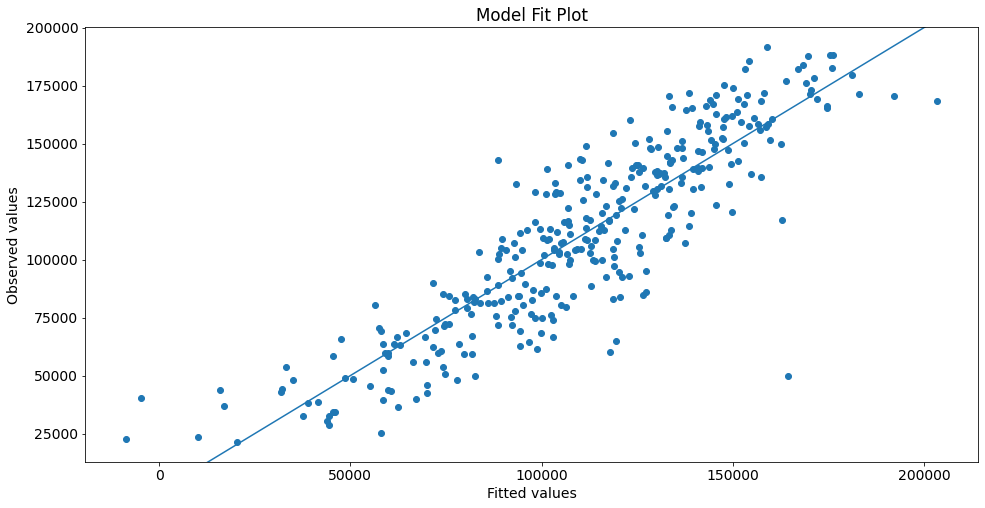

In [728]:
y = scaled_df.pct_prof_boxcox
yhat = boxcox.fittedvalues

fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)

ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

## Outcome

* The results of the regressions consistently show that the 'interaction' variable in the model was statistically significant. In the final model with the box-cox transformation dependent variable and standardized independent variables, the 'interaction' had a p-value of 0.002. This means that it was statistically significant at the 1% level. Since the sign on the coefficient of the 'interaction' variable was positive, it shows that the Ohio Third Grade Reading Guarantee program did have a measurable impact on the reading ability of third grade students in Ohio. This means that I can reject the null hypothesis that the reading program had no impact.
* The null hypothesis of the Breusch-Pagan test for heteroskedasticity indicated that there was no heteroskedasticity present, which meant that there was constant variance in the error term. The test on the final model returned a p-value of .143 which meant that the null hypothesis cannot be rejected. Therefore, there was no heteroskedasticity detected.